<a href="https://colab.research.google.com/github/davidvlaminck/AWVGeneric/blob/master/UseCases/SearchDocumentsFromAssets/documenten_ophalen_obv_dossiernummer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Documenten ophalen op basis van dossiernummer

Download documenten gelinkt aan een specifiek **dossiernunmmer**.

Filter bijkomend op:
- **document type** *\**
- **toezichthouder** *\**
- **provincies** *\**

*\** optioneel

Achterliggend wordt gebruik gemaakt van de [EM-Infra API](https://apps.mow.vlaanderen.be/eminfra/core/swagger-ui/).

Lanceer via de play-knop 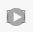
aan de linkerzijde achtereenvolgens ieder blokje code.

De eerste blokjes code dienen om alles te initialiseren. Nadien vragen we je de parameters in te vullen en het eigenlijke script te starten.


In [5]:
import os, shutil
import sys
if os.path.exists('AWVGeneric'):
  shutil.rmtree('AWVGeneric')
!git clone https://github.com/davidvlaminck/AWVGeneric.git
sys.path.insert(0, '/content/AWVGeneric')  # adds the Python files from the GitHub repo to the sys-path.
sys.path.insert(0, '/content/AWVGeneric/UseCases/SearchDocumentsFromAssets')  # adds the Python files from the GitHub repo to the sys-path.

import tempfile
from datetime import datetime
from functions import download_documents
import pandas as pd
import re
from google.colab import files

from API.EMInfraClient import EMInfraClient
from API.EMInfraDomain import DocumentCategorieEnum, QueryDTO, PagingModeEnum, SelectionDTO, ExpressionDTO, TermDTO, \
    OperatorEnum, ExpansionsDTO, construct_naampad, LogicalOpEnum, ApplicationEnum, ProvincieEnum
from pathlib import Path
from API.Enums import AuthType, Environment
from Generic.ExcelModifier import ExcelModifier

import ipywidgets as widgets

Cloning into 'AWVGeneric'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 915 (delta 173), reused 149 (delta 149), pack-reused 713 (from 2)
Receiving objects: 100% (915/915), 974.49 KiB | 18.05 MiB/s, done.
Resolving deltas: 100% (553/553), done.


Lanceer de code via de play-knop en pas onderstaand de parameters aan naar eigen keuze.

In [6]:
# edelta_dossiernummer
widget_dossiernummer = widgets.Text(value='VWT/DVM/2023/3')
print("Dossiernummer:")
display(widget_dossiernummer)

# document categorie
widget_documentcategorie = widgets.SelectMultiple(
    options=[(item.value, item) for item in DocumentCategorieEnum],
    value=[],
    disabled=False
)
print("\n")
print("Selecteer één of meerdere document categoriën (houd SHIFT ingedrukt om meerdere te selecteren):")
display(widget_documentcategorie)

# toezichter
widget_toezichter = widgets.Text(value='Stefan Missotten')
print("\n")
print("Vul de naam (voornaam familienaam) van een toezichter in:")
print("Via de EM-Infra toepassing kunt u controleren of de toezichter bestaat. https://apps.mow.vlaanderen.be/eminfra/admin/gebruikers")
display(widget_toezichter)

# provincie
widget_provincie = widgets.SelectMultiple(
    options=[(item.value, item) for item in ProvincieEnum],
    value=[],
    rows=6,
    disabled=False
)
print("\n")
print("Selecteer één of meerdere provincies (houd SHIFT ingedrukt om meerdere te selecteren):")
display(widget_provincie)


Dossiernummer:


Text(value='VWT/DVM/2023/3')



Selecteer één of meerdere document categoriën (houd SHIFT ingedrukt om meerdere te selecteren):


SelectMultiple(options=(('AANGEBODEN_SERVICES', <DocumentCategorieEnum.AANGEBODEN_SERVICES: 'AANGEBODEN_SERVIC…



Vul de naam (voornaam familienaam) van een toezichter in:
Via de EM-Infra toepassing kunt u controleren of de toezichter bestaat. https://apps.mow.vlaanderen.be/eminfra/admin/gebruikers


Text(value='Stefan Missotten')



Selecteer één of meerdere provincies (houd SHIFT ingedrukt om meerdere te selecteren):


SelectMultiple(options=(('antwerpen', <ProvincieEnum.ANTWERPEN: 'antwerpen'>), ('west-vlaanderen', <ProvincieE…

Controleer de gekozen parameters

In [7]:
# edelta_dossiernummer
edelta_dossiernummer = widget_dossiernummer.value
print(f'Dossiernummer:\t\t\t\t{edelta_dossiernummer}')

# document categorie
document_categorien = [item for item in widget_documentcategorie.value]
print(f'Document categorie/categoriën:\t\t{[item.value for item in document_categorien]}')

# toezichter
toezichter = widget_toezichter.value
print(f'Toezichter:\t\t\t\t{toezichter}')

# provincie
provincie = [item for item in widget_provincie.value]
print(f'Provincie(s):\t\t\t\t{[item.value for item in provincie]}')

Dossiernummer:				VWT/DVM/2023/3
Document categorie/categoriën:		['FOTO']
Toezichter:				Stefan Missotten
Provincie(s):				['vlaams-brabant']


Haal een cookie op volgens [deze instructies](https://sites.google.com/mow.vlaanderen.be/em-infra/afspraken-conventies/awv-cookie-ophalen):

In [8]:
#cookie
widget_cookie = widgets.Text(value='2cfb3172c2434454b07dac14a1ee8359')
print("Vul de cookie in:")
display(widget_cookie)

Vul de cookie in:


Text(value='2cfb3172c2434454b07dac14a1ee8359')

In [9]:
# cookie
cookie = widget_cookie.value
eminfra_client = EMInfraClient(cookie=cookie, auth_type=AuthType.COOKIE, env=Environment.PRD)
print(f"Uw persoonlijke cookie is: {cookie}")

Uw persoonlijke cookie is: 38df78e30da4448a9cbb94517cd7fb08


Lanceer de functie om alle documenten te downloaden. Nadat alle documenten gedownload zijn, worden deze gezipt en wordt de .zip-file automatisch gedownload.

Afhankelijk van de gekozen parameters krijgt u meer/minder bestanden en duurt dit langer.

In [ ]:
output_zip = download_documents(eminfra_client=eminfra_client, edelta_dossiernummer=edelta_dossiernummer,
                    document_categorie=document_categorien, provincie=provincie, toezichter=toezichter)
files.download(output_zip)

Ophalen van alle documenten die voldoen aan volgende criteria:	Document categorie: ['FOTO']	Dossiernummer: VWT/DVM/2023/3	Toezichter: Stefan Missotten	Provincie: ['vlaams-brabant']
Processed 0 assets in 0.83 seconds
Directory '/tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/_geen_bestanden_beschikbaar/A3X9.7__A3N9.7.K' is created or already exists.
Writing file 20160126_124822[1].jpg to temp location: /tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/R0X40.1__R0P40.1.S/FOTO.
Directory '/tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/_geen_bestanden_beschikbaar/A3X7.2__A3P7.2.S__O02__O02.2' is created or already exists.
Directory '/tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/_geen_bestanden_beschikbaar/R0X65.2__R0P65.2.K__R0P65.2.K.LSDeel' is created or already exists.
Directory '/tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/_geen_bestanden_beschikbaar/A3X9.7__A3P9.6.K' is created or already exists.
Directory '/tmp/tmpqil8tlq7/Vlaams-Brabant/Missotten_Stefan/_geen_bestanden_besc